In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, TransformerMixin
import tflearn

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


# Dense classifier

### code for dense classifier of market data

In [47]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train.ravel(), X_test.ravel(), Y_train.ravel(), Y_test.ravel()

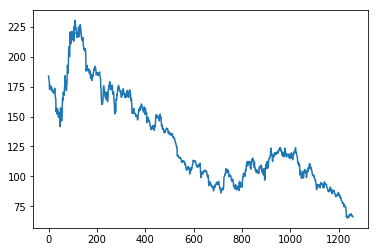

list index out of range


In [48]:
data = pd.read_csv('AAPL5y.csv')[::-1]
data = data.loc[:, 'Adj Close'].tolist()
#print(pd.read_csv('AAPL.csv'))
#print(data)

# Uncomment below to use price change time series
# data = data.ix[:, 'Adj Close'].pct_change().dropna().tolist()

plt.plot(data)
plt.show()

WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 5

# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data), STEP): 
    #print(i)
    #print(i+WINDOW)
    #print(len(data))
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

    except Exception as e:
        print (e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, 0.1)

In [80]:
X_train.shape
X_train.ravel().shape
Y_train.shape
X_test.shape
X_train.shape

(3660,)

Here I will build a Dense classifier using the TF library froms cratch without any  high level API. I followed the Handson-ML chapter 10 Jupyter notebook.

In [50]:
n_inputs = WINDOW # data shape
n_outputs = 2
he_init = he_init = tf.keras.initializers.glorot_uniform(seed=None)

In [67]:
tf.reset_default_graph()

In [68]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')

First we will create a placeholder for our training and test values. These will be a shape of `[none]` to allow for batch processing later.

In [69]:
with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, 600, name="hidden1", kernel_initializer = he_init, activation=tf.nn.leaky_relu)

    hidden2 = tf.layers.dense(hidden1, 150, name="hidden2",kernel_initializer = he_init, activation=tf.nn.leaky_relu)
    
    hidden3 = tf.layers.dense(hidden2, 75, name="hidden3",kernel_initializer = he_init, activation=tf.nn.leaky_relu)

    logits = tf.layers.dense(hidden3, n_outputs, name="outputs")
    y_proba = tf.nn.softmax(logits)

Here we have build our layers. We have 3 hidden layers consisting of 600, 150, then 75 neurons. We then pass our logits from our hidden3 output layer to a softmax function to get the probabilites of y.

In [70]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

Here we state that we are using softmax cross entropy as our loss function using a reduce_mean as the loss parameter.

In [71]:
learning_rate = 0.005
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

Here I am using AdamOptimizer which proved to be the most sucessfull due to its combination of Momentum and RMSProp to power past local minimums.

In [72]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

This is the function stating how we will evaluate our function by calculating the accuracy.

In [73]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [74]:
def fetch_batch(epoch, batch_index, batch_size):
    '''
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(8750, size=batch_size)  # not shown
    X_batch = X_train[indices] # not shown,
    y_batch = y_train.ravel()[indices]#.ravel() # not shown
    return X_batch, y_batch
    '''
    data = pd.read_csv('AAPL5y.csv')[::-1]
    data = data.loc[:, 'Adj Close'].tolist()
    #print(pd.read_csv('AAPL.csv'))
    #print(data)

    # Uncomment below to use price change time series
    # data = data.ix[:, 'Adj Close'].pct_change().dropna().tolist()

    WINDOW = 30
    EMB_SIZE = 1
    STEP = 1
    FORECAST = 5

    # Straightforward way for creating time windows
    X, Y = [], []
    for i in range(0, len(data), STEP): 
        #print(i)
        #print(i+WINDOW)
        #print(len(data))
        try:
            x_i = data[i:i+WINDOW]
            y_i = data[i+WINDOW+FORECAST]  

            last_close = x_i[WINDOW-1]
            next_close = y_i

            if last_close < next_close:
                y_i = [1, 0]
            else:
                y_i = [0, 1] 

        except Exception as e:
            print (e)
            break

        X.append(x_i)
        Y.append(y_i)

    X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
    X, Y = np.array(X), np.array(Y)

    X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, 0.1)
    return X_train, X_test, Y_train, Y_test

Our fetch batch function will fetch small specified batches of our training set to help the model traverse the gradient graph to find the minimum.

In [75]:
from datetime import *
root_logdir = 'C:/Users/Kyle/tf_logs'
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
logdir = "{}/run-{}/".format(root_logdir, now)

loss_summary = tf.summary.scalar('loss_dense', loss)
file_write = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [76]:
n_epochs = 20
n_batches = 500
batch_size = 150

config = tf.ConfigProto(device_count = {'GPU': 1})
config.gpu_options.allow_growth = True

with tf.Session(config = config) as sess:
    init.run()
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, X_test, y_batch, y_test = fetch_batch(epoch, batch_index, batch_size)
            if batch_index %10 == 0:
                summary_str = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch *n_batches + batch_index
                file_write.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
    save_path = saver.save(sess, "./my_model_final.ckpt")



list index out of range


ValueError: Cannot feed value of shape (3660,) for Tensor 'X:0', which has shape '(?, 30)'

In [69]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    accuracy_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
print(accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0.7564


Here I have saved the model for later review.

# TFlearn Dnn net

In [71]:
transformer = Transformer()
X = transformer.fit_transform(df)
y_new = df_new[['default','nonDefault']].values
X = np.float32(X)
y = np.float32(y_new)
pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size = .30)

Now that we have a proper formmated y for use in TFLearn. To start we will build a graph and initalize it to use the gpu.

In [72]:
tf.reset_default_graph()
tf.ConfigProto(device_count = {'GPU': 1})
tflearn.init_graph( gpu_memory_fraction=1)

gpu_options {
  per_process_gpu_memory_fraction: 1
}
allow_soft_placement: true

In [73]:
net = tflearn.input_data(shape=[None, 107])
#net = tflearn.layers.normalization.l2_normalize(net,  107, name='l2')
net = tflearn.fully_connected(net, 575, activation='leaky_relu',
                              name="Layerintro", weights_init = 'xavier')
net = tflearn.dropout(net, 0.7, name="Dropout")


net = tflearn.fully_connected(net, 125, activation='leaky_relu', 
                              name="Layer3", weights_init = 'xavier')

net = tflearn.fully_connected(net, 75, activation='leaky_relu', 
                              name="Layer3", weights_init = 'xavier')





net = tflearn.fully_connected(net, 2, activation='softmax', name="Layer_softmax")
net = tflearn.regression(net, optimizer='Adam', learning_rate=0.005, loss='softmax_categorical_crossentropy')

We can see here the neural net building process is fairly similar. You are declaring layers, activation functions, normalization, and weights initializer's. The main difference is in the final layer. Here int he final layer `tflearn.regression` we are able to easily state the learning_rate, optimizer, and loss function through string declaration. This is easier for fast tuning and optimization but lacks as much tuning features as building your own would in TF.

In [74]:
model = tflearn.DNN(net, tensorboard_verbose=3, tensorboard_dir=root_logdir)

In [75]:
with tf.device('/gpu:0'):
    model.fit( X_train, y_train ,validation_set=( X_test, y_test), 
              n_epoch=10, batch_size = 250, shuffle = True, show_metric=True,)
model.save('myDnnTFLearn.model') 

Training Step: 699  | total loss: 0.48685 | time: 7.407s
| Adam | epoch: 010 | loss: 0.48685 - acc: 0.8227 -- iter: 17250/17500
Training Step: 700  | total loss: 0.49128 | time: 8.564s
| Adam | epoch: 010 | loss: 0.49128 - acc: 0.8184 | val_loss: 0.49339 - val_acc: 0.8141 -- iter: 17500/17500
--
INFO:tensorflow:C:\Users\snoel\Computer Science-F2018\CSUMB-Fall-2018\CST-463\Hw#9\myDnnTFLearn.model is not in all_model_checkpoint_paths. Manually adding it.


In [76]:
print(model.evaluate(X_test,y_test))

[0.8141333331108094]
